# Dataset Curation

This notebook provides functionality for preparing, manipulating and exploring datasets associated with the machine learning problem (refer to Section 3.2 of the report).

A small exemplary dataset is provided to test functionality. 
Data should follow the directory structure:

```example_data/
├── 01_manifest.csv
├── foo/
│   └── bar.wav
└── baz/
    └── kaz.wav
```

`01_manifest.csv` follows the below schema, where the `manual_tag` column denotes the assigned raw ground truth label.

```
filename,package_hash,manual_tag
bar.wav,foo,ba-do-bi
kaz.wav,baz,ta-bi-me
```

In [2]:
import pathlib
import shutil
import pandas as pd
import numpy as np
import soundfile as sf
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

# Package Utilities

Utility functions for manipulating datasets

In [3]:
def get_tag_set(tag):
    # Creates a set object from a 'manual_tag' string
    # Manually entered tags are nominally delimited with a '-' character
    # get_tag_set('ab-cd-ef') -> set('ab', 'cd', 'ef')
    
    s = set(tag.split('-'))
    s.discard('')
    return s

def set_union(subsets):
    # performs a set union on a list of subsets
    # set_union([set('ab', 'cd', 'ef'), set('ab', 'gh')]) -> set('ab', 'cd', 'ef', 'gh')
    return set.union(*subsets)
    
def one_to_many(df, from_col='category_set', to_col='category'):
    # distributes a single snippet (row), with multiple assigned tags/categories, to multiple rows,
    # one with each each individual tag/category in the to_col entry.
    
    dfs = []
    # get all the unique category/tag values
    unique = set_union(df[from_col].values)
    for u in unique:
        # create a new dataframe with index of the single unique category/tag, and values of all the rows
        # of the original dataframe where the set in the from_col contains that unique category/tag
        # append it to a list
        dfs.append(pd.concat({u: df.loc[df[from_col].apply(lambda x: u in x), :]}, names=[to_col]))
    # join them all together, and reset the index so the single category is a column
    return pd.concat(dfs).droplevel(1).reset_index()

def many_to_one(df):
    # reverses the one to many operation, keeping one row per unique snippet.
    # assumes the useful 'category_set' column still exists in df (you'll probably want to use it)
    return df.groupby(['filename','package_hash']).first().reset_index().drop('category', axis=1)

def supports(df, on_col='category'):
    # Determines the support (number of datapoints) in the group defined by the 'on_col' column
    return df.groupby(on_col).size()

def copy_to_new_package(df, source_root, destination_root):
    # copy the files from df 
    # (e.g at source_root/package_hash/filename.wav) to a new package (e.g at destination_root/package_hash/filename.wav )
    
    # make subfolders
    [(destination_root/x).mkdir() for x in df.groupby('package_hash').groups.keys()]
    # perform the copy
    df.apply(lambda x: shutil.copy(source_root/x['package_hash']/x['filename'], destination_root/x['package_hash']/x['filename']), axis=1)
    
    # write a manifest csv and pickle file
    df.to_csv(destination_root/'01_manifest.csv', index=False)
    df.to_pickle(destination_root/'01_manifest.pkl')

# Listen Utilities
Utility functions for listening and viewing spectrograms

In [4]:
# settings for generating the mel spectrogram
# refer to librosa.feature.melspectrogram for more information
mel_settings = {'fmax': 8000, 'power': 2, 'n_mels' :128, 'n_fft':2048, 'hop_length':512}


def get_mels(filepath='', data=[], fs=None, force_shape=None):
    # Returns the mel spectrogram for a given file (will be loaded from disk), OR 
    # a specified array of audio samples, sampled at fs Hz
    # If filepath AND fs is specified, the file will be read (converted if needed) at this sampling rate, 
    # otherwise fs=None uses the native file rate.
    # force_shape=(n,m) will pad or truncate the spectrogram to a given array size 
    # useful if the audio is not the nominal length
    
    if filepath:
        # load from disk
        data, fs = librosa.load(filepath, sr=fs)
    else:
        # Simple paramter checks if using specified samples
        assert (len(data>0) and fs >0), 'Must provide either a filename, or array of data and sample rate'
    
    # generate the spectrogram using the specified settings
    S = librosa.feature.melspectrogram(y=data, 
                                   sr = fs, **mel_settings)
    
    if force_shape and S.shape != force_shape:
        
        S = force_array_shape(S, force_shape)
            
    return S, fs

def force_array_shape(x, force_shape):
    # Forces a numpy array to a specific shape by filling with zeros, or truncating
    pad_widths = []
    
    for ax, ax_length in enumerate(force_shape):
        # iterate over each axis
        if x.shape[ax] >= ax_length:
            # input is larger than forced shape along this axis
            # take a slice of the required length
            x = x.take(indices=range(0,ax_length), axis=ax)
        
        # note the pad width for this axis
        # if the above branch was taken, will be (0,0), and the following pad will do nothing for that axis
        # if it wasn't taken, will be (0,n), meaning we need n 0's padded to that axis to conform to the shape
        pad_widths.append((0,ax_length-x.shape[ax]))
        
    # perform the pad
    x = np.pad(x, pad_widths)
    return x

def plot_mels(filepath='', data=[], fs=None):
    # plots the mel spectrogram for a given file, OR given sample data
    
    mels, fs = get_mels(filepath, data, fs)
    
    plt.figure()
    librosa.display.specshow(librosa.power_to_db(mels), y_axis='mel', x_axis='time', fmax=mel_settings['fmax'], 
                             hop_length = mel_settings['hop_length'], sr=fs)
    plt.show()

def change_gain(data, gain):
    # scale sample data (adjust volume)
    data *= gain
    return data.clip(-1.0, 1.0)

def listen_to_file(filename, gain, **kwargs):
    # listen to audio file, and display the spectrogram
    # input 'r' to repeat, 'volume=100' to change gain, or anything else to exit the loop
    
    _input = 'r'
    
    # read samples and adjust gain
    data, fs = sf.read(filename)

    data = change_gain(data, gain)

    if kwargs.get('plot',True):
        # plot the spectrogram
        plot_mels(data=data, fs=fs) 
    
    # listening loop
    while _input == 'r':  # replay tag
        ipd.display(ipd.Audio(data, rate=fs, autoplay=True))
        ipd.set_matplotlib_close(close=True)
        _input = input()
        if _input.startswith('volume'):
            try:
                old_gain = gain
                gain = float(_input.split('=')[1]) / 100.0
                data = change_gain(data, gain)
                print('Gain set to {}'.format(gain))
            except:
                print(
                    'Volume could not be set! Enter "volume=100" (normal), "volume=200" (Louder), "volume=800" (Even Louder), "volume=50" (Quieter) etc')
            else:
                _input = 'r'
    
    return _input, gain


def listen_to_files(df, data_root, *args, **kwargs):
    """
    Listen to audio files specified as per the rows of the dataframe.
    files are located at data_root/package_hash/filename.wav
    
    kwargs
        random (bool): shuffle rows of the dataframe
        n (int): total number of snippets to listen to 
        plot (bool): plot a spectrogram
    """
    subset = df
    gain = 1.0
    
    # shuffle or not
    if kwargs.pop('random',True):
        subset = subset.sample(frac=1)
    
    # loop over specified number (or all) of the rows
    for i,row in subset.iloc[:kwargs.pop('n',None)].iterrows():
        print(row)
        file = data_root/row['package_hash']/row['filename']
        print(file)
        try:
            _input, gain = listen_to_file(file, gain, **kwargs)
            if _input =='q':
                break
        except Exception as e:
            print('Error Listening to {}, with error: {}'.format(file, e))


# Initial Exploration
Listen to some audio files and observe their spectrograms

In [5]:
# set your path here
data_root = pathlib.Path('/Volumes/Clavius/documents/Documents/Employment/NoiseNet/Development/tag_data/processed/')#pathlib.Path('example_data/') #
manifest_path = data_root/'01_manifest.csv'

# read the manifest in
manifest = pd.read_csv(manifest_path)
manifest.head()

,filename,package_hash,manual_tag
0,2019-02-19 19_39_18.wav,635_cnnmodel_20190220_verification_package,ba-do
1,2019-02-06 13_14_24.wav,635_cnnmodel_20190220_verification_package,ta-do
2,2019-02-19 19_46_53.wav,635_cnnmodel_20190220_verification_package,ba-do
3,2019-02-17 19_23_04.wav,635_cnnmodel_20190220_verification_package,cr-do
4,2019-02-19 19_03_00.wav,635_cnnmodel_20190220_verification_package,wi-ba


filename        2019-10-05T09_03_13+0930.wav
package_hash                            beva
manual_tag                          ta-do-me
Name: 8, dtype: object
example_data/beva/2019-10-05T09_03_13+0930.wav


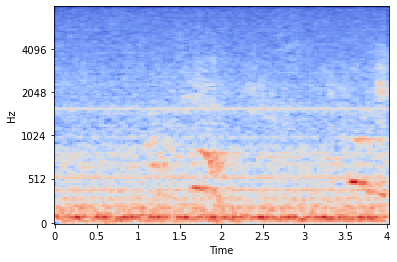

/var/folders/h_/3897vprx49s9nnqw3tzb7vgc0000gn/T/ipykernel_54858/4207421376.py:84: DeprecationWarning: `set_matplotlib_close` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_close()`
  ipd.set_matplotlib_close(close=True)



filename        2021-01-01T15_17_22+1030.wav
package_hash                            oxdh
manual_tag                             do-ca
Name: 9, dtype: object
example_data/oxdh/2021-01-01T15_17_22+1030.wav


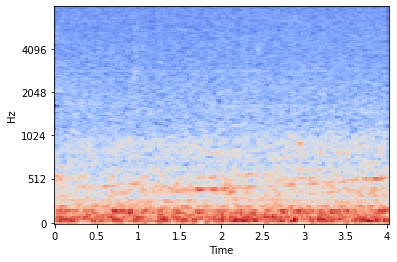


filename        14113-4-0-1.wav
package_hash          u8k_fold1
manual_tag             drilling
Name: 10, dtype: object
example_data/u8k_fold1/14113-4-0-1.wav


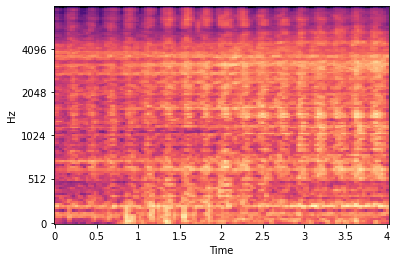

In [34]:
# listen to files and view spectrograms as desired.
# filter the first argument dataframe as desired to listen to whatever specific snippets you want
# e.g. listen_to_snippets(manifest, data_root, random=True, n=5)

# enter "r" to repeat playback, or "q" to quit gracefully. 
# enter "volume=200" to double the gain, 
# enter "volume=50" to halve the gain, etc.
# anything else will continue to the next file
listen_to_files(manifest, data_root, random=True, n=3)

# Perform category assignment

From the supplied tags, assign the final class label(s) to the audio file

In [6]:
# class mapping from 'manual_tag' element, to final human readable class label
category_mapping = {" do": "animal_dogs", "a": "indeterminate", "ae": "", "at": "human_voice", "b": "background",
                    "ba": "background", "baa": "background", "bar": "background", "bbi": "animal_birds",
                    "bca": "background", "bcr": "background", "be": "signals_bell", "bi": "animal_birds",
                    "bia": "animal_birds", "bib": "animal_birds", "bir": "animal_birds", "bme": "mechanical",
                    "bs": "mechanical_construction", "bwi": "nature_wind", "bz": "digital_distortion",
                    "c": "transport_car", "ca": "transport_car", "ccr": "animal_insects", "ce": "animal_insects",
                    "cer": "animal_insects", "ch": "animal_poultry", "ck": "animal_cockatoo",
                    "cl": "digital_distortion", "cme": "mechanical", "cr": "animal_insects", "cre": "animal_insects",
                    "ct": "animal_crow", "cw": "animal_other", "cz": "human_movement", "db": "indeterminate",
                    "dg": "animal_dogs", "didi": "digital_distortion", "dl": "human_movement", "do": "animal_dogs",
                    "dob": "animal_dogs", "doi": "animal_dogs", "don": "animal_dogs", "dor": "animal_dogs",
                    "ds": "human_movement", "du": "animal_poultry", "f": "", "fr": "animal_other",
                    "ft": "human_movement", "ga": "animal_birds", "ge": "animal_other", "go": "indeterminate",
                    "gr": "mechanical_construction", "ha": "mechanical_construction", "he": "transport_aircraft",
                    "ho": "signals_horn", "hu": "human_movement", "i": "mechanical_impulsive",
                    "im": "mechanical_impulsive", "in": "indeterminate", "is": "animal_insects", "lo": "indeterminate",
                    "ls": "", "m": "mechanical", "ma": "mechanical", "Mar": "mechanical", "me": "mechanical",
                    "mec": "mechanical", "meow": "animal_other", "mer": "mechanical", "mi": "signals_tone",
                    "mo": "transport_motorcycle", "mp": "indeterminate", "mr": "mechanical", "mu": "music",
                    "mw": "mechanical", "na": "nature_rain", "ne": "mechanical", "nu": "music", "o": "animal_dogs",
                    "ol": "transport_aircraft", "pf": "human_movement", "ph": "signals_bell",
                    "pl": "transport_aircraft", "ps": "human_movement", "R": "", "r": "", "r'": "", "ra": "nature_rain",
                    "ro": "animal_poultry", "sh": "animal_other", "si": "signals_siren",
                    "sp": "mechanical_construction", "t": "human_voice", "ta": "human_voice", "tar": "human_voice",
                    "tdoa": "human_voice", "tf": "human_movement", "th": "mechanical_impulsive", "tl": "signals_bell",
                    "tr": "transport_train", "va": "mechanical_construction", "w": "nature_wind",
                    "we": "mechanical_construction", "wef": "mechanical_construction", "wf": "mechanical_construction",
                    "wh": "signals_bell", "wi": "nature_wind", "wib": "nature_wind", "wo": "mechanical_construction",
                    "ya": "", "air_conditioner": "mechanical", "car_horn": "signals_horn",
                    "children_playing": "human_voice", "dog_bark": "animal_dogs", "drilling": "mechanical_construction",
                    "engine_idling": "transport_car", "gun_shot": "mechanical_impulsive",
                    "jackhammer": "mechanical_construction", "siren": "signals_siren", "street_music": "music",
                    "#NAME?": ""}

# consider only these categories
considered_categories_large = ["animal_dogs", "animal_insects", "animal_birds", "animal_cockatoo", "animal_poultry",  "background","human_voice",  "indeterminate","mechanical", "mechanical_construction", "mechanical_impulsive","nature_wind", "signals_horn", "signals_siren", "transport_car"]
considered_categories_small = ['animal_dogs', 'animal_birds', 'human_voice', 'transport_car', 'mechanical']

In [7]:
# assign a set of tags to each row
manifest['tag_set'] = manifest['manual_tag'].apply(get_tag_set)
# from these individual tags, perform the lookup and assign the set of categories
manifest['category_set'] = manifest['tag_set'].apply(lambda x: {category_mapping[t] for t in x})
manifest.head()

,filename,package_hash,manual_tag,tag_set,category_set
0,2019-02-19 19_39_18.wav,635_cnnmodel_20190220_verification_package,ba-do,"{ba, do}","{animal_dogs, background}"
1,2019-02-06 13_14_24.wav,635_cnnmodel_20190220_verification_package,ta-do,"{ta, do}","{human_voice, animal_dogs}"
2,2019-02-19 19_46_53.wav,635_cnnmodel_20190220_verification_package,ba-do,"{ba, do}","{animal_dogs, background}"
3,2019-02-17 19_23_04.wav,635_cnnmodel_20190220_verification_package,cr-do,"{cr, do}","{animal_insects, animal_dogs}"
4,2019-02-19 19_03_00.wav,635_cnnmodel_20190220_verification_package,wi-ba,"{ba, wi}","{nature_wind, background}"


In [8]:
# Perform the one-to-many assignment to flatten category set into individual categories
# each row (snippet) may appear more than once in the categorised dataframe, once for each category of noise 
# that was tagged in the snippet
categorised = one_to_many(manifest, from_col='category_set', to_col='category')
categorised

considered_small = categorised[categorised['category'].apply(lambda x: x in considered_categories_small)]
considered_large = categorised[categorised['category'].apply(lambda x: x in considered_categories_large)]


Text(0.5, 1.0, 'Class Supports')

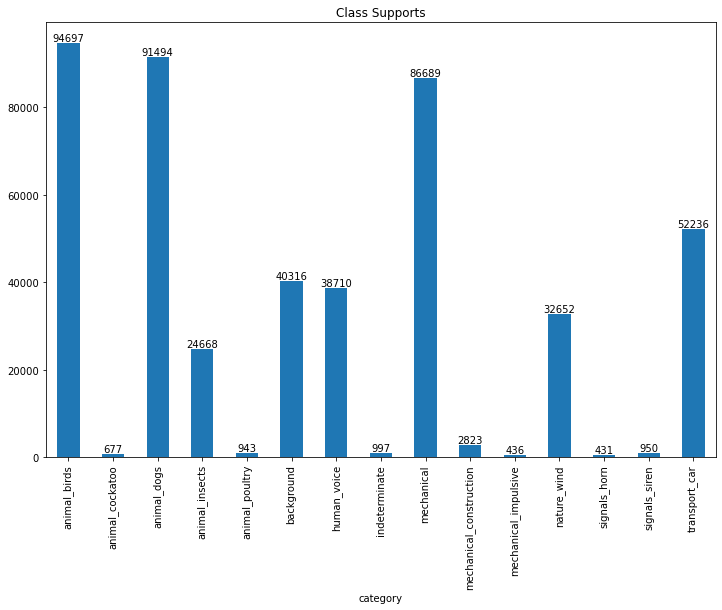

In [15]:
# show the supports for each category
tag_counts = supports(considered_large, on_col='category')
plt.figure(figsize=(12,8))
ax = tag_counts.plot(kind='bar')
ax.bar_label(ax.containers[0])
plt.title('Class Supports')

## Category supports for full dataset

The below supports are generated for the entire available dataset

![Class supporrts for full dataset](images/class_supports.png) 

## Create a small dataset for designing and early validation of models.
It can be useful to create a smaller package to work with in the early stages of model development.

In [32]:
categorised_sample = considered_large.sample(n=5000)
categorised_sample_one = many_to_one(categorised_sample)
categorised_sample_one

new_dest = data_root.parent/'sample_set'
new_dest.mkdir(exist_ok=True)

copy_to_new_package(categorised_sample_one, new_dest)